In [107]:
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

### Utility functions

In [108]:
def custom_distance(dist):
    """Custom distance function"""
    return dist * np.exp(dist)

def normalize(x):
    """Feature-wise normalization"""
    return (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))

def standardize(x):
    """Feature-wise standarization"""
    return (x - x.mean(axis=0)) / x.std(axis=0)

In [109]:
def predict_and_plot(model: KNeighborsClassifier, X_test: pd.DataFrame, y_test: pd.DataFrame):
    """
    Run inference on the given model and plot confusion matrix
    with confusion matrix-based metrics.
    """
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred, zero_division=0))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test.squeeze())
    plt.show()


def eval_knn(
        data: pd.DataFrame, 
        k: int = 5, 
        weights: str = "uniform", 
        metric: str = "minkowski", 
        cv: str = 5, 
        preprocess: callable = lambda x: x,
        stratify: bool = False,
        repeats: int = 1
    ):
    """
    Evaluates KNN for given parameters
    """
    if weights == "custom":
        weights = custom_distance

    # Split data and preprocess
    X, y = np.split(data, [-1], axis=1)
    X = preprocess(X)

    # Choose folding mode
    if stratify:
        kfold = RepeatedStratifiedKFold(n_splits=cv, n_repeats=repeats)
    else:
        kfold = RepeatedKFold(n_splits=cv, n_repeats=repeats)

    # Run cross validation
    cv_scores = []

    for train_idx, test_idx in kfold.split(X, y):
        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]

        model = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=weights)
        model.fit(X_train, y_train.squeeze())
        y_pred = model.predict(X_test)

        score = f1_score(y_test, y_pred, average='macro')
        cv_scores.append(score)

    return cv_scores


def benchmark_cross_validation(data: pd.DataFrame, cvs: List[int], preprocess: callable = lambda x: x, stratify: bool = False, repeats: int = 1):
    """
    Benchmark cross validation for given fold values
    """
    cv_scores = {cv: eval_knn(data, cv=cv, preprocess=preprocess, stratify=stratify, repeats=repeats) for cv in cvs}
    cv_scores = pd.DataFrame.from_dict(cv_scores, orient='index')

    print(cv_scores.T.describe())
    
    fig = cv_scores.T.boxplot(figsize=(12, 6))
    fig.set_xlabel("Number of folds")
    fig.set_ylabel("F1-score")
    fig.set_title("Boxplots of F1-score for different values of folds in cross-validation")


def knn_grid_search(
    data: pd.DataFrame, 
    metrics: List[str],
    weights: List[int], 
    k: int, 
    cv: int, 
    preprocess: callable = lambda x: x,
    stratify: bool = False,
    repeats: int = 1
):
    """
    Plots grid search for metrics and weights and plots series of boxplots
    """
    main_fig, axes = plt.subplots(len(weights), len(metrics), figsize=(20, 12), sharey=True, sharex=True)
    main_fig.suptitle("Boxplots of F1-score", fontsize=20)

    for i, weight in enumerate(weights):
        for j, metric in enumerate(metrics):
            scores = {ki: eval_knn(data, ki, weight, metric, cv, preprocess=preprocess, stratify=stratify, repeats=repeats) for ki in range(1, k)}
            scores = pd.DataFrame.from_dict(scores, orient='index')

            fig = scores.T.boxplot(ax=axes[i, j])
            fig.set_title(f"weights={weight}, metric={metric}")

            if i == len(weights) - 1:
                fig.set_xlabel("Number of neighbours")

            if j == 0:
                fig.set_ylabel("F1-score")

    plt.tight_layout()
    plt.show()

# IRIS

## 1. Ładowanie zbioru danych

In [110]:
dir = "../Lista 0/zbiory/iris.data"
iris_data = pd.read_csv(dir, names=["sepal-length", "sepal-width", "petal-length", "petal-width", "class"])

iris_data.head()

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## 2. Trenowanie z domyślnymi parametrami

Klasyfikator KNN jako domyślnych wartości używa:
* ilość sąsiadów: $2$
* metryka: Minkowski z $p = 2$, czyli Euklides 
* głosowanie (weight): większościowe (uniform)

### 2.1 Podział zbioru

2.1.1. Random split

Dzielimy zbiór na losowe podzbiory podanej wielkości.

In [111]:
train_data, test_data = train_test_split(iris_data, train_size=0.8)

X_train, y_train = np.split(train_data, [-1], axis=1)
X_test, y_test = np.split(test_data, [-1], axis=1)

2.1.2. Stratified split

Najpierw dzielimy zbiór na podzbiory według przynależności do klasy, a następnie dla każdego podzbioru dokonujemy losowego podziału na zbiór treningowy i testowy według zadanych wielkości. W taki sposób zapewniamy, że rozkład klas w zbiorze treningowym jak i testowym jest taki sam - klasy są równie dobrze reprezentowane.

In [112]:
train_data, test_data = train_test_split(iris_data, train_size=0.8, stratify=iris_data["class"])

X_train_str, y_train_str = np.split(train_data, [-1], axis=1)
X_test_str, y_test_str = np.split(test_data, [-1], axis=1)

### 2.2 Wyniki dla róznych typów preprocessing'u.

2.1.1. No preprocessing

a) Random split

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         7
Iris-versicolor       1.00      0.85      0.92        13
 Iris-virginica       0.83      1.00      0.91        10

       accuracy                           0.93        30
      macro avg       0.94      0.95      0.94        30
   weighted avg       0.94      0.93      0.93        30



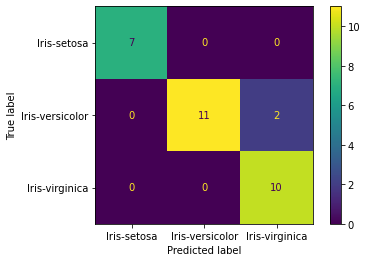

In [113]:
model = KNeighborsClassifier()
model.fit(X_train, y_train.squeeze())

predict_and_plot(model, X_test, y_test)

b) Stratified split

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



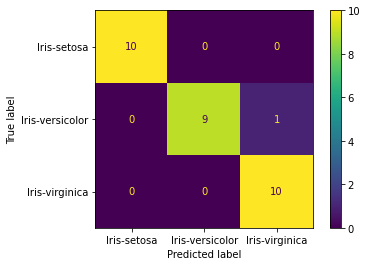

In [114]:
model = KNeighborsClassifier()
model.fit(X_train_str, y_train_str.squeeze())

predict_and_plot(model, X_test_str, y_test_str)

2.1.2. Standarization

Standaryzacja danych polega na odjęciu średniej i podzieleniu przez odchylenie standardowe.

a) Random split

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         7
Iris-versicolor       0.93      1.00      0.96        13
 Iris-virginica       1.00      0.90      0.95        10

       accuracy                           0.97        30
      macro avg       0.98      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



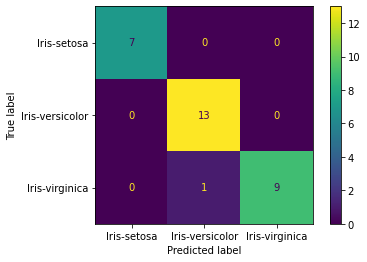

In [115]:
X_train_std = standardize(X_train)
X_test_std = standardize(X_test)

model = KNeighborsClassifier()
model.fit(X_train_std, y_train.squeeze())

predict_and_plot(model, X_test_std, y_test)

b) Stratified split

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.80      0.80      0.80        10
 Iris-virginica       0.80      0.80      0.80        10

       accuracy                           0.87        30
      macro avg       0.87      0.87      0.87        30
   weighted avg       0.87      0.87      0.87        30



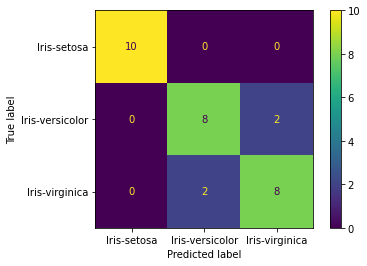

In [116]:
X_train_std = standardize(X_train_str)
X_test_std = standardize(X_test_str)

model = KNeighborsClassifier()
model.fit(X_train_std, y_train_str.squeeze())

predict_and_plot(model, X_test_std, y_test_str)

2.1.3. Normalization

Normalizacja danych polega na odjęciu minimum i podzielenie przez długość przedziału - wartości po normalizacji są z zakresu $[0, 1]$.

a) Random split

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         7
Iris-versicolor       1.00      0.77      0.87        13
 Iris-virginica       0.77      1.00      0.87        10

       accuracy                           0.90        30
      macro avg       0.92      0.92      0.91        30
   weighted avg       0.92      0.90      0.90        30



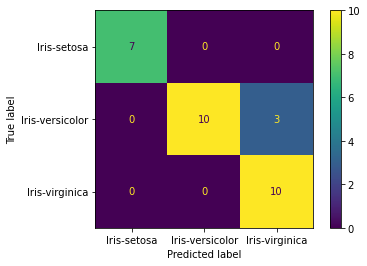

In [117]:
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

model = KNeighborsClassifier()
model.fit(X_train_norm, y_train.squeeze())

predict_and_plot(model, X_test_norm, y_test)

b) Stratified split

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.70      0.82        10
 Iris-virginica       0.77      1.00      0.87        10

       accuracy                           0.90        30
      macro avg       0.92      0.90      0.90        30
   weighted avg       0.92      0.90      0.90        30



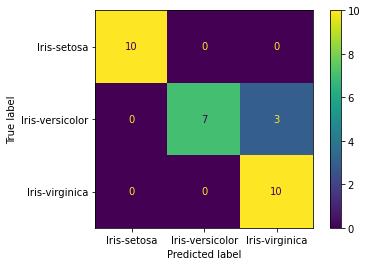

In [118]:
X_train_norm = normalize(X_train_str)
X_test_norm = normalize(X_test_str)

model = KNeighborsClassifier()
model.fit(X_train_norm, y_train_str.squeeze())

predict_and_plot(model, X_test_norm, y_test_str)

## 3. Trenowanie z walidacją krzyżową

Testujemy trzy różne ilości splitów: 2, 5, 10.

### 3.1 Walidacja krzyżowa z losowymi splitami

              2          5           10
count  20.000000  50.000000  100.000000
mean    0.945712   0.961552    0.963357
std     0.020489   0.035883    0.046716
min     0.910331   0.857143    0.822222
25%     0.934394   0.939646    0.925926
50%     0.945825   0.966241    1.000000
75%     0.959081   1.000000    1.000000
max     0.974762   1.000000    1.000000


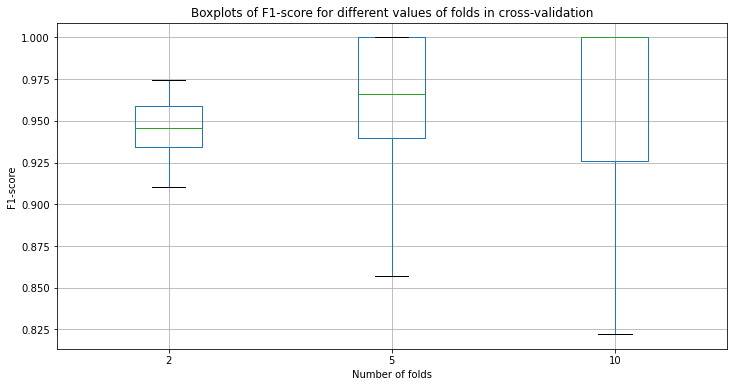

In [119]:
benchmark_cross_validation(iris_data, cvs=[2, 5, 10], repeats=10)

### 3.2 Walidacja krzyżowa ze stratyfikowanymi splitami

              2          5           10
count  20.000000  50.000000  100.000000
mean    0.959203   0.968531    0.966960
std     0.019665   0.026581    0.043439
min     0.919872   0.899749    0.797980
25%     0.946323   0.966583    0.932660
50%     0.959855   0.966583    1.000000
75%     0.973291   1.000000    1.000000
max     0.986661   1.000000    1.000000


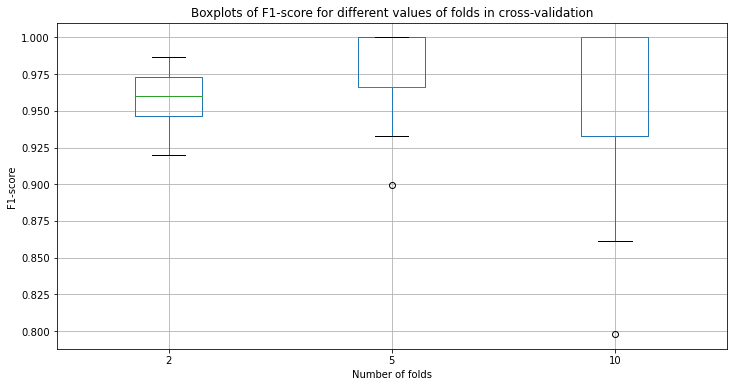

In [120]:
benchmark_cross_validation(iris_data, cvs=[2, 5, 10], stratify=True, repeats=10)

## 4. Porównanie jakości modelu dla różnych wartości parametrów

Na podstawie powyższych eksperymentów będziemy używać:
* walidacji krzyżowej z 5 foldami
* bez preprocessing'u

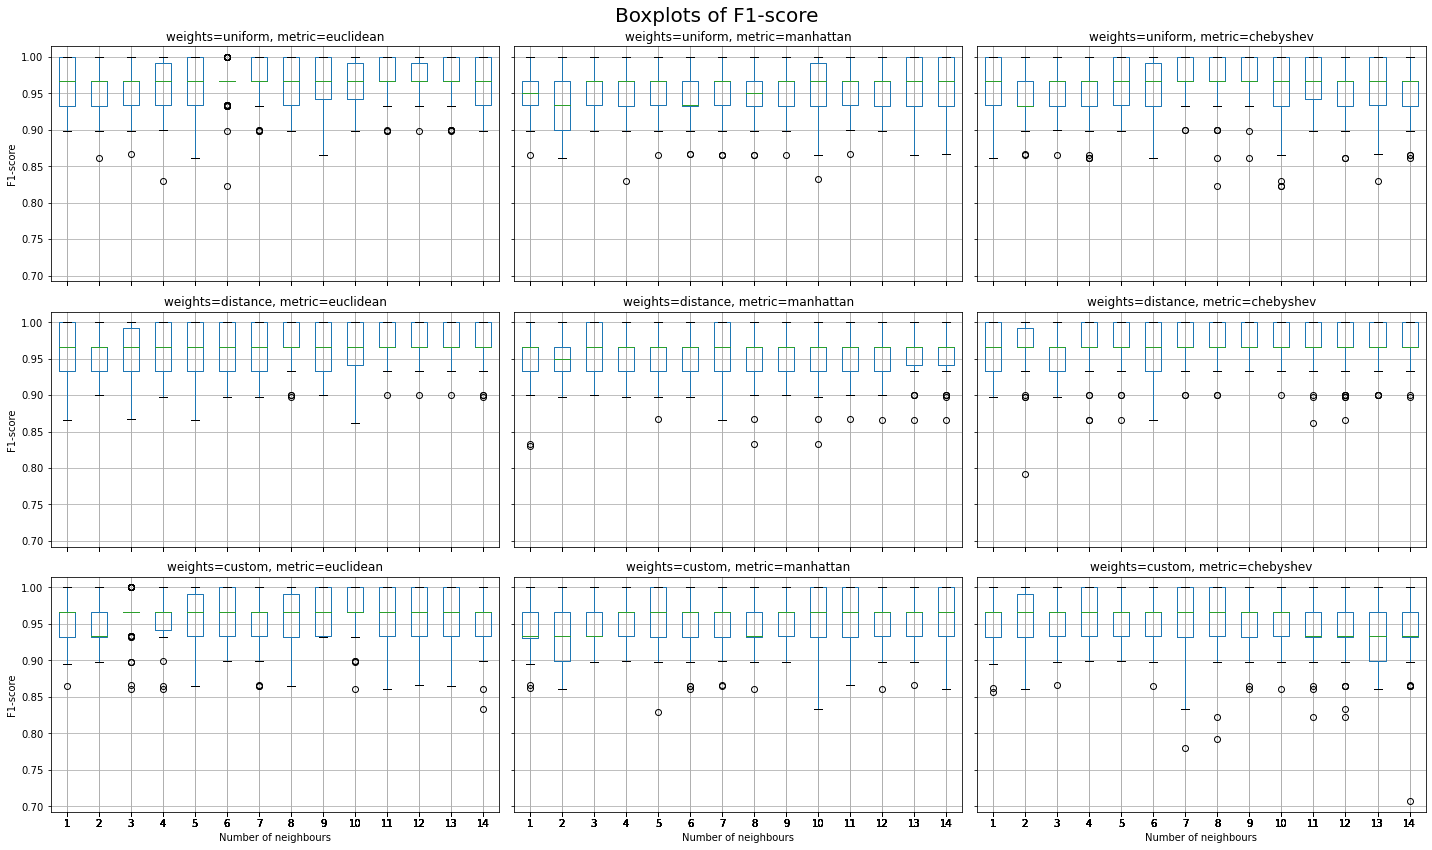

In [121]:
knn_grid_search(
    iris_data, 
    metrics=["euclidean", "manhattan", "chebyshev"], 
    weights=["uniform", "distance", "custom"], 
    k=15, 
    cv=5, 
    stratify=True,
    repeats=10
)

# GLASS

## 1. Ładowanie zbioru danych

In [122]:
dir = "../Lista 0/zbiory/glass.data"
glass_data = pd.read_csv(dir, names=["RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "class"]).reset_index()
glass_data = glass_data.drop("index", axis=1)
#glass_data['class'] = glass_data['class'].astype(str)
glass_data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


## 2. Trenowanie z domyślnymi parametrami

Klasyfikator KNN jako domyślnych wartości używa:
* ilość sąsiadów: $2$
* metryka: Minkowski z $p = 2$, czyli Euklides 
* głosowanie (weight): większościowe (uniform)

### 2.1 Podział zbioru

2.1.1. Random split

In [123]:
train_data, test_data = train_test_split(glass_data, train_size=0.8)

X_train, y_train = np.split(train_data, [-1], axis=1)
X_test, y_test = np.split(test_data, [-1], axis=1)

2.1.2. Stratified split

In [124]:
train_data, test_data = train_test_split(glass_data, train_size=0.8, stratify=glass_data["class"])

X_train_str, y_train_str = np.split(train_data, [-1], axis=1)
X_test_str, y_test_str = np.split(test_data, [-1], axis=1)

### 2.2 Wyniki dla różnych typów preprocessing'u.

2.1.1. No preprocessing

a) Random split

              precision    recall  f1-score   support

         1.0       0.79      0.73      0.76        15
         2.0       0.83      0.67      0.74        15
         3.0       0.50      1.00      0.67         2
         5.0       0.75      0.75      0.75         4
         6.0       0.67      1.00      0.80         2
         7.0       0.83      1.00      0.91         5

    accuracy                           0.77        43
   macro avg       0.73      0.86      0.77        43
weighted avg       0.79      0.77      0.77        43



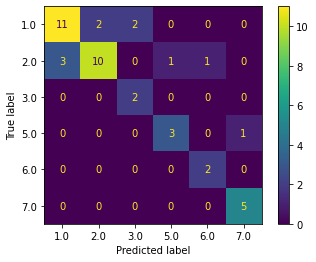

In [125]:
model = KNeighborsClassifier()
model.fit(X_train, y_train.squeeze())

predict_and_plot(model, X_test, y_test)

b) Stratified split

              precision    recall  f1-score   support

         1.0       0.60      0.64      0.62        14
         2.0       0.69      0.73      0.71        15
         3.0       0.50      0.33      0.40         3
         5.0       0.50      0.33      0.40         3
         6.0       1.00      0.50      0.67         2
         7.0       0.57      0.67      0.62         6

    accuracy                           0.63        43
   macro avg       0.64      0.53      0.57        43
weighted avg       0.63      0.63      0.62        43



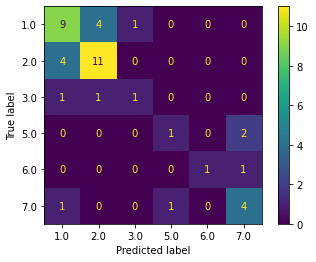

In [126]:
model = KNeighborsClassifier()
model.fit(X_train_str, y_train_str.squeeze())

predict_and_plot(model, X_test_str, y_test_str)

2.1.2. Standarization

a) Random split

              precision    recall  f1-score   support

         1.0       0.77      0.67      0.71        15
         2.0       0.59      0.67      0.62        15
         3.0       0.00      0.00      0.00         2
         5.0       0.60      0.75      0.67         4
         6.0       1.00      1.00      1.00         2
         7.0       1.00      1.00      1.00         5

    accuracy                           0.70        43
   macro avg       0.66      0.68      0.67        43
weighted avg       0.69      0.70      0.69        43



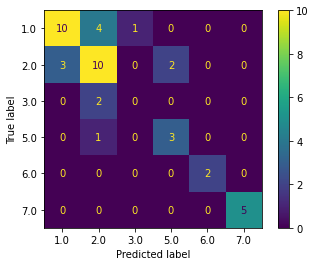

In [127]:
X_train_std = standardize(X_train)
X_test_std = standardize(X_test)

model = KNeighborsClassifier()
model.fit(X_train_std, y_train.squeeze())

predict_and_plot(model, X_test_std, y_test)

b) Stratified split

              precision    recall  f1-score   support

         1.0       0.59      0.71      0.65        14
         2.0       0.55      0.73      0.63        15
         3.0       0.00      0.00      0.00         3
         5.0       0.00      0.00      0.00         3
         6.0       1.00      1.00      1.00         2
         7.0       1.00      0.67      0.80         6

    accuracy                           0.63        43
   macro avg       0.52      0.52      0.51        43
weighted avg       0.57      0.63      0.59        43



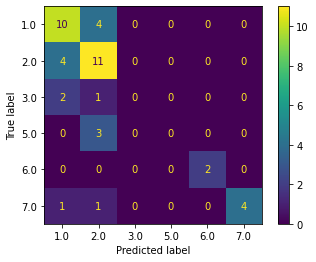

In [128]:
X_train_std = standardize(X_train_str)
X_test_std = standardize(X_test_str)

model = KNeighborsClassifier()
model.fit(X_train_std, y_train_str.squeeze())

predict_and_plot(model, X_test_std, y_test_str)

2.1.3. Normalization

a) Random split

              precision    recall  f1-score   support

         1.0       0.77      0.67      0.71        15
         2.0       0.60      0.80      0.69        15
         3.0       0.00      0.00      0.00         2
         5.0       1.00      0.50      0.67         4
         6.0       1.00      0.50      0.67         2
         7.0       0.71      1.00      0.83         5

    accuracy                           0.70        43
   macro avg       0.68      0.58      0.59        43
weighted avg       0.70      0.70      0.68        43



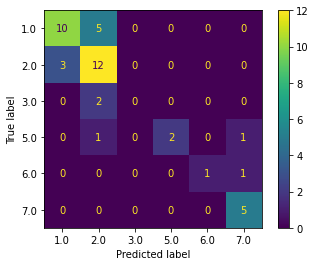

In [129]:
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

model = KNeighborsClassifier()
model.fit(X_train_norm, y_train.squeeze())

predict_and_plot(model, X_test_norm, y_test)

b) Stratified split

              precision    recall  f1-score   support

         1.0       0.38      0.36      0.37        14
         2.0       0.43      0.60      0.50        15
         3.0       0.00      0.00      0.00         3
         5.0       0.67      0.67      0.67         3
         6.0       1.00      0.50      0.67         2
         7.0       1.00      0.83      0.91         6

    accuracy                           0.51        43
   macro avg       0.58      0.49      0.52        43
weighted avg       0.51      0.51      0.50        43



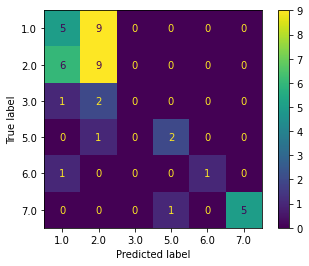

In [130]:
X_train_norm = normalize(X_train_str)
X_test_norm = normalize(X_test_str)

model = KNeighborsClassifier()
model.fit(X_train_norm, y_train_str.squeeze())

predict_and_plot(model, X_test_norm, y_test_str)

## 3. Trenowanie z walidacją krzyżową

Testujemy trzy różne ilości splitów: 2, 5, 10.

### 3.1 Walidacja krzyżowa z losowymi splitami

              2          5           10
count  20.000000  50.000000  100.000000
mean    0.486200   0.550937    0.551822
std     0.073146   0.094241    0.133351
min     0.324815   0.328755    0.172308
25%     0.429805   0.500161    0.470677
50%     0.497819   0.554635    0.550944
75%     0.546316   0.614413    0.639056
max     0.620955   0.714775    0.844612


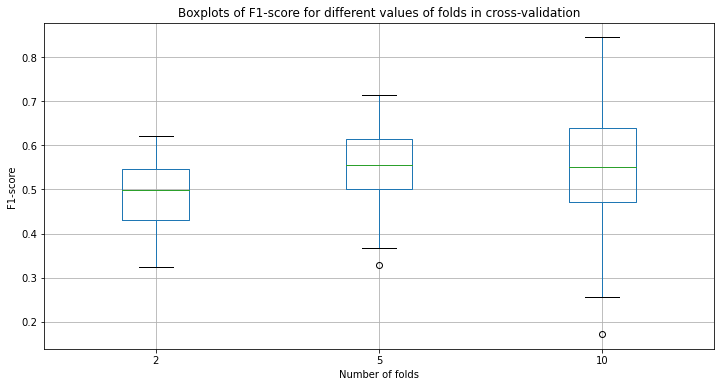

In [131]:
benchmark_cross_validation(glass_data, cvs=[2, 5, 10], preprocess=standardize, repeats=10)

### 3.2 Walidacja krzyżowa ze stratyfikowanymi splitami

/home/patryk/anaconda3/envs/dnn/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
/home/patryk/anaconda3/envs/dnn/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
/home/patryk/anaconda3/envs/dnn/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
/home/patryk/anaconda3/envs/dnn/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
/home/patryk/anaconda3/envs/dnn/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 

              2          5           10
count  20.000000  50.000000  100.000000
mean    0.508091   0.560821    0.547079
std     0.072071   0.086608    0.125215
min     0.380314   0.378355    0.233333
25%     0.452704   0.507840    0.468182
50%     0.495855   0.559901    0.543966
75%     0.550731   0.624628    0.641915
max     0.637815   0.779570    0.768519


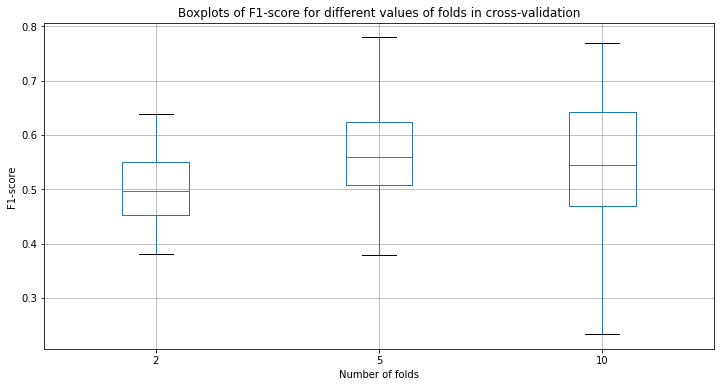

In [132]:
benchmark_cross_validation(glass_data, cvs=[2, 5, 10], preprocess=standardize, stratify=True, repeats=10)

## 4. Porównanie jakości modelu dla różnych wartości parametrów

Na podstawie powyższych eksperymentów będziemy używać:
* walidacji krzyżowej z 5 foldami
* standaryzacja

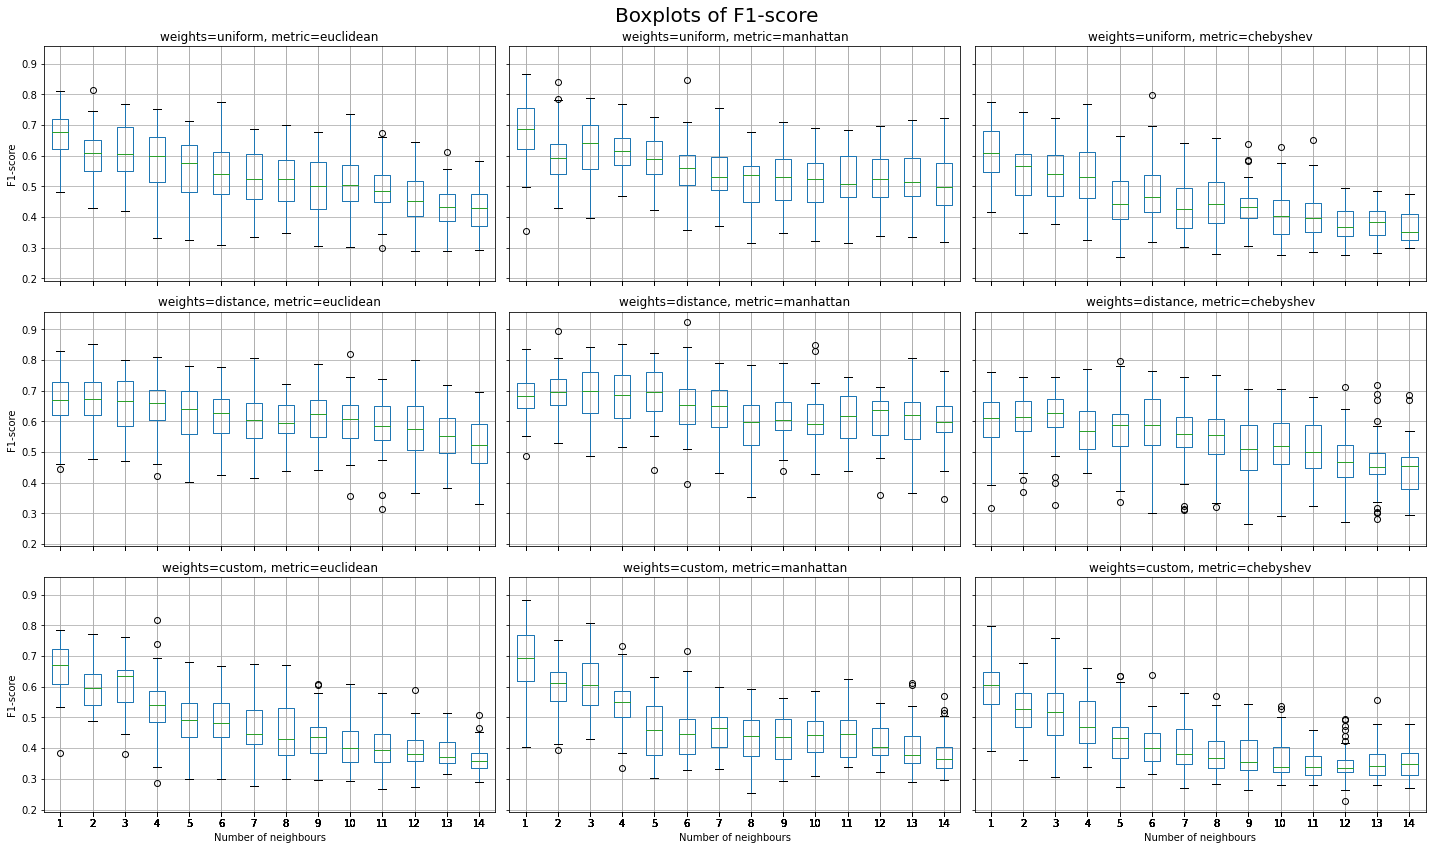

In [133]:
knn_grid_search(
    glass_data, 
    metrics=["euclidean", "manhattan", "chebyshev"], 
    weights=["uniform", "distance", "custom"], 
    k=15, 
    cv=5, 
    preprocess=standardize,
    stratify=True,
    repeats=10
)

# WINE

## 1. Ładowanie zbioru danych

In [134]:
dir = "../Lista 0/zbiory/wine.data"
wine_data = pd.read_csv(
    dir, 
    names=[
        "class", "Alcohol", "Malic acid", "Ash", "Alcanity of ash", "Magnesium", 
        "Total phenols", "Flavanoids", "Nonflavanoid phenosis", "Proanthocyanins",
        "Color intensity", "Hue", "OD280/OD315 of diluted wine", "Proline"
    ]
)

wine_data = wine_data[list(wine_data.columns.values)[1:] + ["class"]]

wine_data.head()

,Alcohol,Malic acid,Ash,Alcanity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenosis,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wine,Proline,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


## 2. Trenowanie z domyślnymi parametrami

Klasyfikator KNN jako domyślnych wartości używa:
* ilość sąsiadów: $2$
* metryka: Minkowski z $p = 2$, czyli Euklides 
* głosowanie (weight): większościowe (uniform)

### 2.1 Podział zbioru

2.1.1. Random split

In [135]:
train_data, test_data = train_test_split(wine_data, train_size=0.8)

X_train, y_train = np.split(train_data, [-1], axis=1)
X_test, y_test = np.split(test_data, [-1], axis=1)

2.1.2. Stratified split

In [136]:
train_data, test_data = train_test_split(wine_data, train_size=0.8, stratify=wine_data["class"])

X_train_str, y_train_str = np.split(train_data, [-1], axis=1)
X_test_str, y_test_str = np.split(test_data, [-1], axis=1)

### 2.2 Wyniki dla różnych typów preprocessing'u.

2.1.1. No preprocessing

a) Random split

              precision    recall  f1-score   support

         1.0       0.82      0.90      0.86        10
         2.0       0.92      0.67      0.77        18
         3.0       0.42      0.62      0.50         8

    accuracy                           0.72        36
   macro avg       0.72      0.73      0.71        36
weighted avg       0.78      0.72      0.74        36



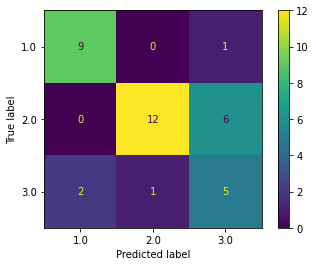

In [137]:
model = KNeighborsClassifier()
model.fit(X_train, y_train.squeeze())

predict_and_plot(model, X_test, y_test)

b) Stratified split

              precision    recall  f1-score   support

         1.0       0.79      0.92      0.85        12
         2.0       0.83      0.71      0.77        14
         3.0       0.70      0.70      0.70        10

    accuracy                           0.78        36
   macro avg       0.77      0.78      0.77        36
weighted avg       0.78      0.78      0.78        36



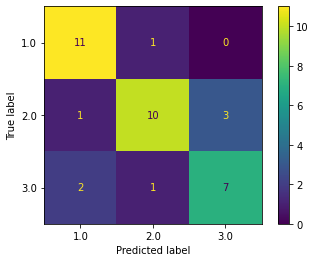

In [138]:
model = KNeighborsClassifier()
model.fit(X_train_str, y_train_str.squeeze())

predict_and_plot(model, X_test_str, y_test_str)

2.1.2. Standarization

a) Random split

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        10
         2.0       1.00      0.89      0.94        18
         3.0       0.80      1.00      0.89         8

    accuracy                           0.94        36
   macro avg       0.93      0.96      0.94        36
weighted avg       0.96      0.94      0.95        36



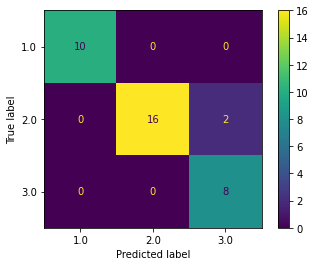

In [139]:
X_train_std = standardize(X_train)
X_test_std = standardize(X_test)

model = KNeighborsClassifier()
model.fit(X_train_std, y_train.squeeze())

predict_and_plot(model, X_test_std, y_test)

b) Stratified split

              precision    recall  f1-score   support

         1.0       0.92      1.00      0.96        12
         2.0       1.00      0.86      0.92        14
         3.0       0.91      1.00      0.95        10

    accuracy                           0.94        36
   macro avg       0.94      0.95      0.95        36
weighted avg       0.95      0.94      0.94        36



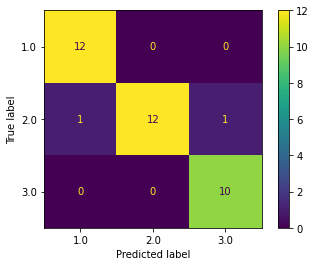

In [140]:
X_train_std = standardize(X_train_str)
X_test_std = standardize(X_test_str)

model = KNeighborsClassifier()
model.fit(X_train_std, y_train_str.squeeze())

predict_and_plot(model, X_test_std, y_test_str)

2.1.3. Normalization

a) Random split

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        10
         2.0       1.00      0.89      0.94        18
         3.0       0.80      1.00      0.89         8

    accuracy                           0.94        36
   macro avg       0.93      0.96      0.94        36
weighted avg       0.96      0.94      0.95        36



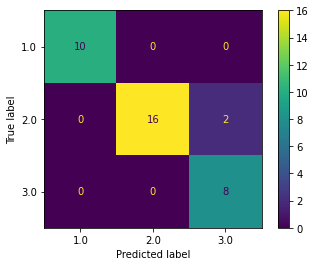

In [141]:
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

model = KNeighborsClassifier()
model.fit(X_train_norm, y_train.squeeze())

predict_and_plot(model, X_test_norm, y_test)

b) Stratified split

              precision    recall  f1-score   support

         1.0       0.86      1.00      0.92        12
         2.0       1.00      0.86      0.92        14
         3.0       1.00      1.00      1.00        10

    accuracy                           0.94        36
   macro avg       0.95      0.95      0.95        36
weighted avg       0.95      0.94      0.94        36



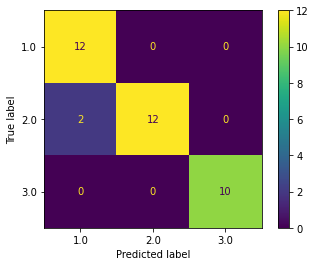

In [142]:
X_train_norm = normalize(X_train_str)
X_test_norm = normalize(X_test_str)

model = KNeighborsClassifier()
model.fit(X_train_norm, y_train_str.squeeze())

predict_and_plot(model, X_test_norm, y_test_str)

## 3. Trenowanie z walidacją krzyżową

Testujemy trzy różne ilości splitów: 2, 5, 10.

### 3.1 Walidacja krzyżowa z losowymi splitami

              2          5           10
count  20.000000  50.000000  100.000000
mean    0.952402   0.954400    0.950490
std     0.019063   0.032376    0.048107
min     0.909957   0.864409    0.816783
25%     0.945012   0.939406    0.924002
50%     0.954368   0.945787    0.950089
75%     0.966933   0.973872    1.000000
max     0.977805   1.000000    1.000000


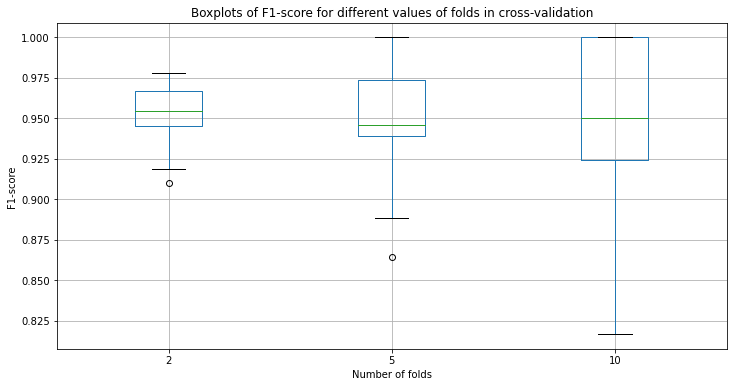

In [143]:
benchmark_cross_validation(wine_data, cvs=[2, 5, 10], preprocess=normalize, repeats=10)

### 3.2 Walidacja krzyżowa ze stratyfikowanymi splitami

              2          5           10
count  20.000000  50.000000  100.000000
mean    0.951385   0.957100    0.957541
std     0.023119   0.030071    0.044006
min     0.899538   0.887566    0.830484
25%     0.943834   0.943307    0.944056
50%     0.955830   0.970110    0.948718
75%     0.966302   0.974321    1.000000
max     0.989705   1.000000    1.000000


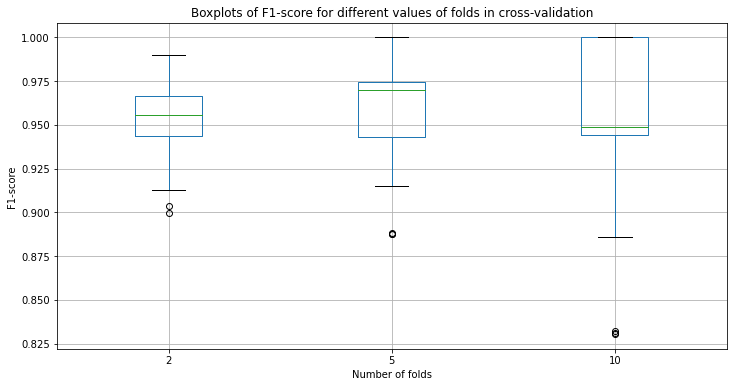

In [144]:
benchmark_cross_validation(wine_data, cvs=[2, 5, 10], preprocess=normalize, stratify=True, repeats=10)

## 4. Porównanie jakości modelu dla różnych wartości parametrów

Na podstawie powyższych eksperymentów będziemy używać:
* walidacji krzyżowej z 10 foldami
* normalizacja

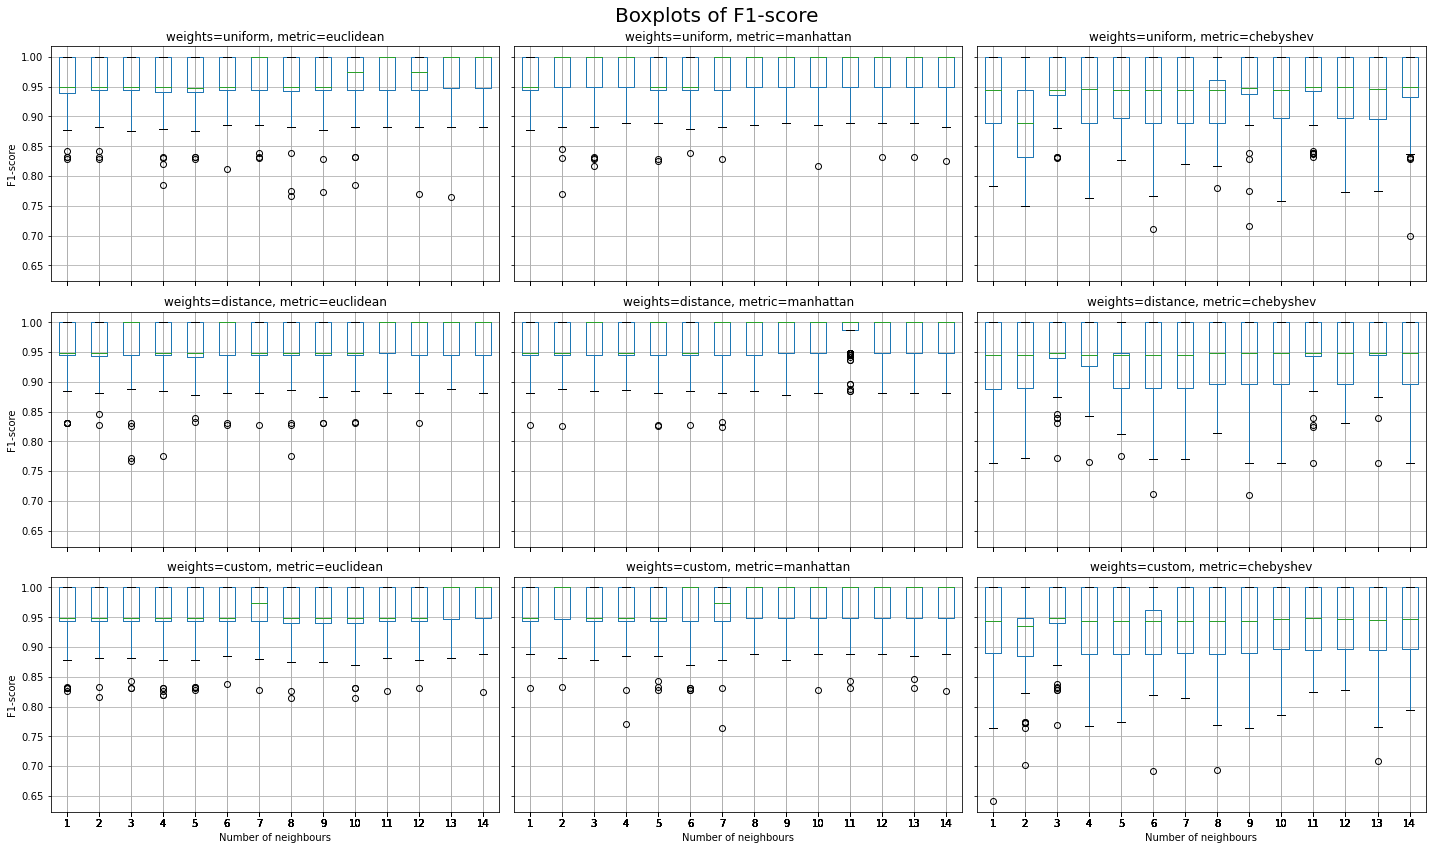

In [145]:
knn_grid_search(
    wine_data, 
    metrics=["euclidean", "manhattan", "chebyshev"], 
    weights=["uniform", "distance", "custom"], 
    k=15, 
    cv=10, 
    preprocess=normalize,
    stratify=True,
    repeats=10
)

# Pytania

### 1. Czy powinno używać się procedury mieszania danych (tj. *shuffle*)?

Odp: Dla modeli używających batchy, mieszanie danych jest zalecane, aby ograniczyć overfitting - nie wchodzą do modelu co epokę te same dane. W przypadku k-nn mieszanie danych nie ma za bardzo zastosowania z tego względu, że dla k-nn kolejność danych nie jest istotna. Predykcja jest wykonywana na podstawie szukania przykładów treningowych o najmniejszej odległości od ewaluowanej próbki - operacja minimum jest symetryczna, daje ten sam wynik bez znaczenia na permutacje danych.

### 2. Co jest modelem klasyfikacji w tym zadaniu? Dlaczego k-nn jest typu *lazy learning*?

Odp: W tym zadaniu klasyfikacja nowej próbki jest dokonywana na podstawie szukania najbardziej podobnych do niej próbek (sąsiadów) ze zbioru treningowego. Na podstawie odległości sąsiadów oraz ich klas predykowana jest klasa nowej próbki. K-nn jest typu *lazy-learning*, gdyż nie wymaga żadnego wcześniejszego uczenia - model zapamiętuje tylko próbki jakie otrzymał w zbiorze treningowym i tylko w ramach inferencji dokonuje obliczeń. 

### 3. Ile parametrów ma klasyfikator k-nn? Które z nich są istotne dla skuteczności?

Odp:

### 4. Czym się różni walidacja krzyżowa stratyfikowana od "zwykłej"?

Odp: Podział stratyfikowany polega na podzieleniu zbioru na podzbiory w taki sposób aby wszystkie klasy były równo reprezentowane w każdym z podzbiorów.

### 5. Dlaczego zwykle nie stosujemy walidacji krzyżowej *leave-one-out*?

Odp:

### 6. Czy k-nn wymaga standaryzacji/normalizacji danych?

Odp:

### 7. Dlaczego miara Accuracy dla zbiorów niezbalansowanych jest mniej użyteczna niż miara F-score?

Odp: